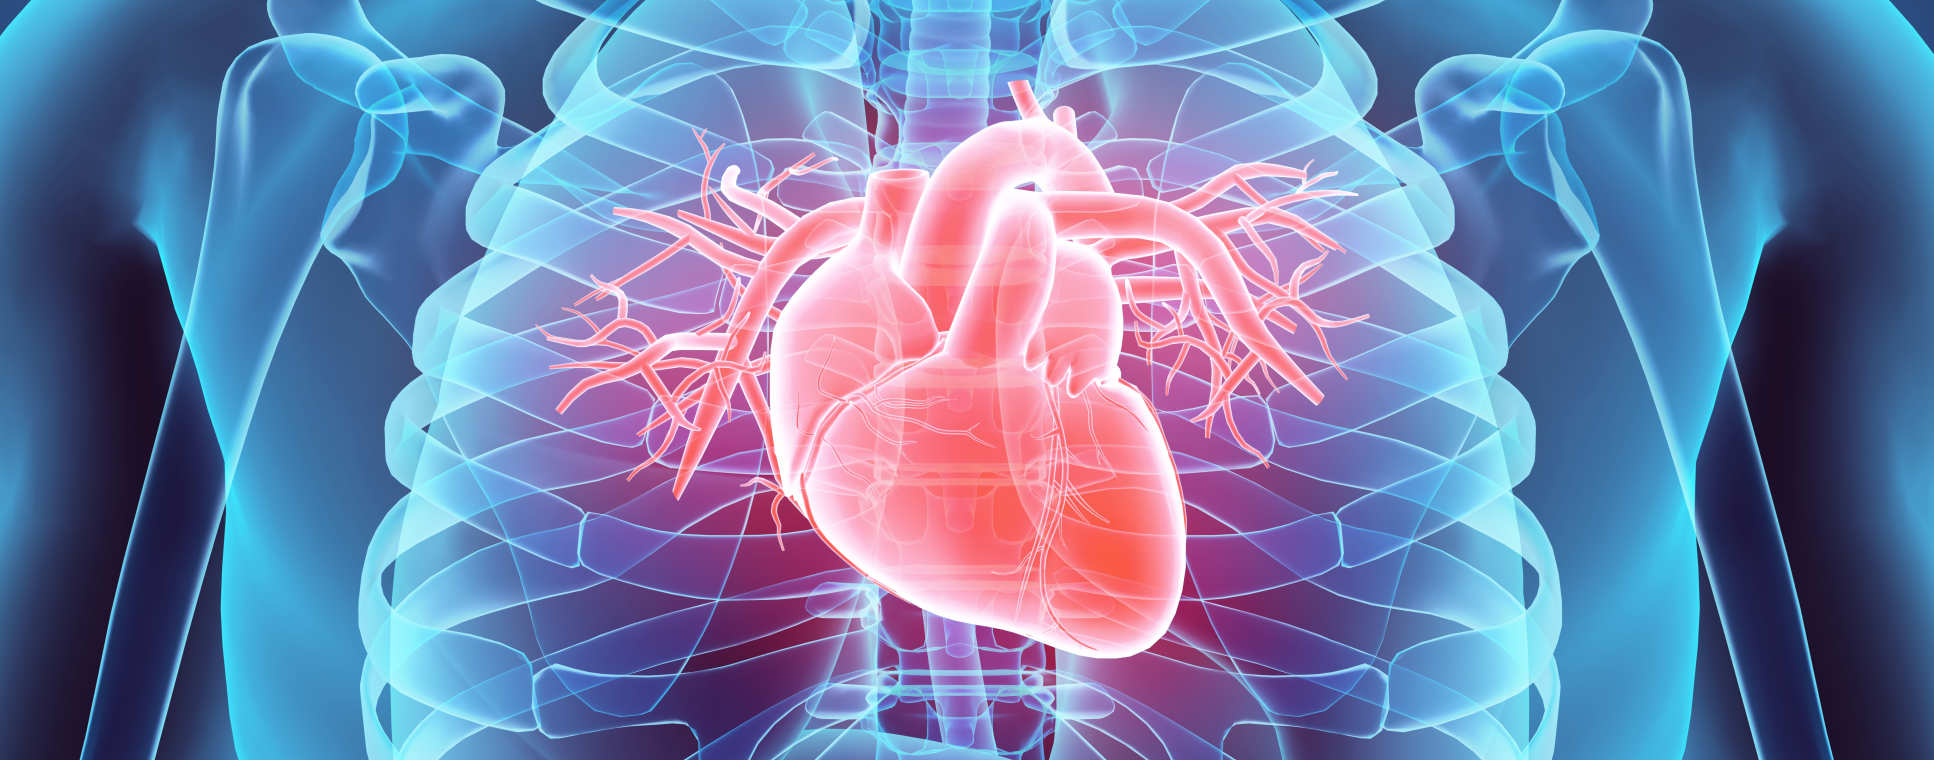

# **cardiovascular disease**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve,plot_precision_recall_curve

%matplotlib inline

In [ ]:
url='../input/cardiovascular-disease-dataset/cardio_train.csv'
# load the data
data=pd.read_csv(url,sep=";")


In this Dataset named "Cardiovascular Disease dataset", We'll try to analyze and gather the insights of dataset and predict the possibility of a person having Cardiovascular disease based on various parameters specified in this dataset.


#### **There are 3 types of input features**:
- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.<br><br>
 #### **Features**:<br>
- **Age** | Objective Feature | age | int (days)<br>
- **Height** | Objective Feature | height | int (cm) |<br>
- **Weight** | Objective Feature | weight | float (kg) |<br>
- **Gender** | Objective Feature | gender | categorical code |<br>
- **Systolic blood pressure** | Examination Feature | ap_hi | int |<br>
- **Diastolic blood pressure** | Examination Feature | ap_lo | int |<br>
- **Cholesterol** | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
- **Glucose** | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
- **Smoking** | Subjective Feature | smoke | binary |<br>
- **Alcohol intake** | Subjective Feature | alco | binary |<br>
- **Physical activity** | Subjective Feature | active | binary |<br>
- **Presence or absence of cardiovascular disease** | *Target Variable* | cardio | binary |<br><br>
All of the dataset values were collected at the moment of medical examination.<br></font></span></left>

In [ ]:
data.head()

In [ ]:
#get information about the data features, the amount of instances and the amount of Nan values.
data.info()

As you can see there are no null values in the data frame. Delete the 'id' feature that does not provide important information.

In [ ]:
data=data.drop(columns='id')

The 'Age' feature counts age by days. Convert it to age by years.

In [ ]:
data['age']=data['age']/365
sns.histplot(data=data,x='age',bins=20,hue='cardio',palette="dark:darkred", alpha=0.5)

The data show that the ages of the sampled are between **30-65**. It can also be clearly seen that age affects the disease.

Show the data distribution in the different categories:

In [ ]:
f, axes = plt.subplots(1, 7, figsize=(15, 5), sharex=False,sharey=True)
sns.countplot(x='gender',data=data,ax=axes[0],palette="Set2")
sns.countplot(x='smoke',data=data,ax=axes[1],palette="Set2")
sns.countplot(x='alco',data=data,ax=axes[2],palette="Set2")
sns.countplot(x='gluc',data=data,ax=axes[3],palette="Set2")
sns.countplot(x='cholesterol',data=data,ax=axes[4],palette="Set2")
sns.countplot(x='active',data=data,ax=axes[5],palette="Set2")
sns.countplot(x='cardio',data=data,ax=axes[6],palette="Set2")

In [ ]:
data.describe()


There are many entries that need to be cleared or corrected in the data. Unreasonable blood pressure values can be seen, as well as height and weight values.

In [ ]:
data.duplicated().sum()

In [ ]:
data.drop_duplicates(inplace=True) #delete duplicates values.

In [ ]:
#plot relation height-weight by gender
f, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data=data, x="height", y="weight",hue='gender',palette="dark:darkred", alpha=0.5)
ax.axvline(120, ls='--',ymax=0.85)
ax.axvline(215, ls='--',ymax=0.85)
ax.axhline(30, ls='--',xmin=0.3,xmax=0.835)
plt.title("Height and weight ratio according to gender")
plt.show()

Delete unreasonable height and weight data.

In [ ]:
data=data.query('height >= 120 & height <=215 & weight >= 30')

We will add to the data feature 'bmi' according to the following formula:

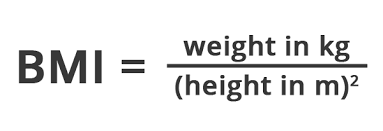

This feature represents the 'height' ,'weight' features and can therefore be deleted.

In [ ]:
data['bmi'] = data['weight']/((data['height']/100)**2)
data=data.drop(['height','weight'],axis=1)

In [ ]:
sns.histplot(data=data,x='bmi',hue='cardio',kde=True,bins=30,palette='bright')
plt.title('Effect of high blood pressure on "cardio" feature')
plt.show()

You can see that there is a higher incidence of heart disease among 'bmi' higher.
Delete unreasonable values:

In [ ]:
data=data.query('bmi <= 50')


The following are blood pressure indicators:

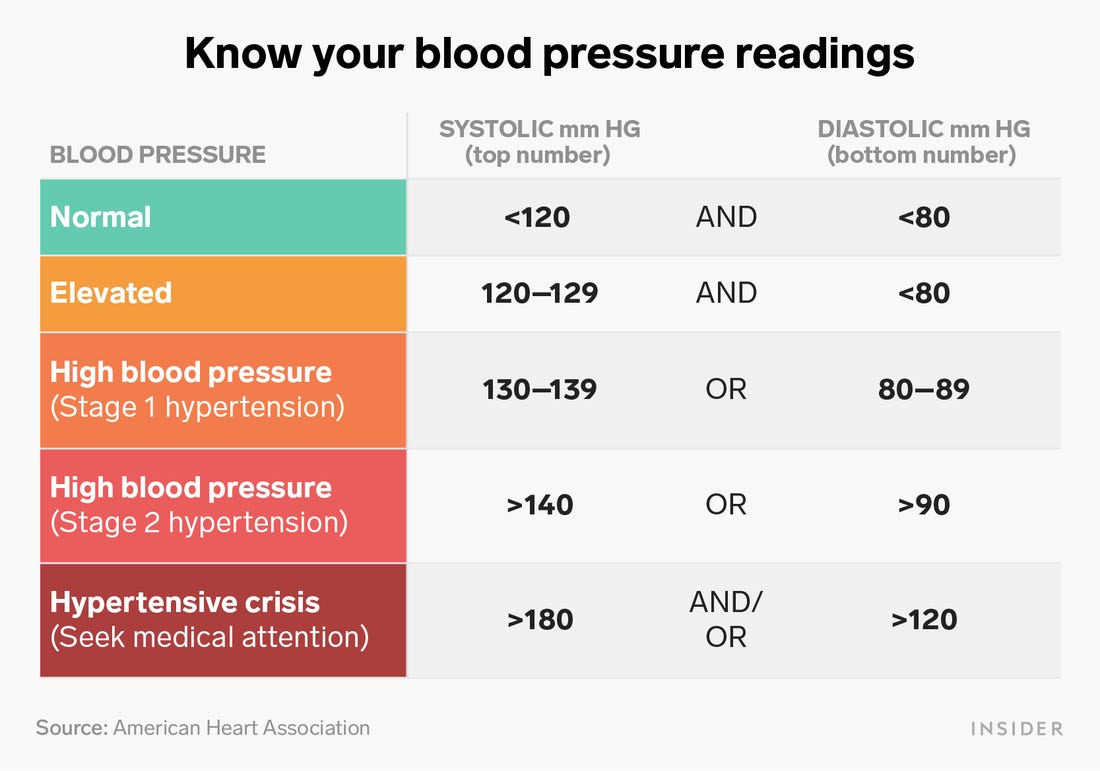

Delete unreasonable values (diastolic higher than systolic, numbers out of measurement range):

In [ ]:
data=data.query('70 < ap_hi < 240 & 40 < ap_lo < 180 & ap_hi> ap_lo')

now examine the distribution of patients by blood pressure.

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True,sharey=True)
sns.histplot(data, x="ap_hi", hue="cardio",bins=15,palette='bright',stat="density",ax=axes[1])
sns.histplot(data, x="ap_lo", hue="cardio",bins=15,palette='bright',stat="density",ax=axes[0])
f.suptitle('Effect of blood pressure on "cardio" feature')
plt.show()

see the correlation between the different features:

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize = (13,10))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

It can be seen that the factors that mainly affect the 'cardio' feature are: blood pressure, cholesterol, age and bmi.

Delete the subjective columns that have no correlation with the target feature. 

In [ ]:
data=data.drop(['active','alco','smoke'],axis=1)

# Model

Delete the target label from the dataframe and store it separately:

In [ ]:
X = data.drop(['cardio'],axis=1)
y = data['cardio'].copy()

Split the data into a training set and a test set:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

Standardize the data to allow the model to better study the data.

In [ ]:
scaler=StandardScaler()

X_train_s=X_train.copy()
X_train_s[['age','ap_hi','ap_lo','bmi']]=scaler.fit_transform(X_train_s[['age','ap_hi','ap_lo','bmi']])
normalized_x_train = pd.DataFrame(X_train_s, columns = X_train.columns)
X_train=normalized_x_train
X_test_s=X_test.copy()
X_test_s[['age','ap_hi','ap_lo','bmi']]=scaler.transform(X_test_s[['age','ap_hi','ap_lo','bmi']])
normalized_x_test = pd.DataFrame(X_test_s, columns = X_test.columns)
X_test=normalized_x_test

Before the first model, we will test the dummy model. This model is supposed to give us a perspective on whether the real models we will create are really useful in forecasting or even the dummy gives such a forecast ...

In [ ]:
dum=DummyClassifier(strategy='prior')
dum.fit(X_train,y_train)
dum_pre=dum.predict(X_test)
dum.score(X_test,y_test)

### Knn

Run on the 1-100 range and check the accuracy percentage of the KNN model given n which is the number of neighbors.

In [ ]:
k_range = list(range(1, 101))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test,y_test))
# m is the best value of n_neighbors 
m=scores.index(max(scores))+1
#plot graph showing percentage of accuracy by number of neighbors
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, scores)
ax.axvline(m, ls='--',ymax=max(scores)+0.2,c='r',solid_capstyle='round')
ax.text(x=m+2,y=0.66,s=m,fontsize=22)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


this is the number of neighbors that brings the highest percentage of accuracy and therefore we will define the KNN model according to it.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=m)
knn.fit(X_train, y_train)
knn_pre=knn.predict(X_test)
knn.score(X_test,y_test)

View the confusion matrix:

In [ ]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)
con=confusion_matrix(y_train, y_train_pred)

#plot confusion_matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(con,fmt=".0f", annot=True,linewidths=0.2, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actually")

In [ ]:
# print a recall, precision, and f1 score report:
print(classification_report(y_test,knn_pre))

In conclusion, the model appears to make a better prediction of disease negation (recall of '0')

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pre=rf.predict(X_test)
rf.score(X_test,y_test)

In [ ]:
#plot confusion_matrix
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=5)
con=confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(con,fmt=".0f", annot=True,linewidths=0.2, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actually")

In [ ]:
# print a recall, precision, and f1 score report:
print(classification_report(y_test,rf_pre))

The Random Forest Classifier model seems to perform less well than the knn. Let us see the **ROC** graph, and a graph describing the **precision-recall** relation.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8),sharex=True)

plot_roc_curve(knn, X_test, y_test,ax=ax1)
plot_roc_curve(rf, X_test, y_test,ax=ax1,linestyle=':')
plot_roc_curve(dum, X_test, y_test,ax=ax1,linestyle='--')
plot_precision_recall_curve(knn, X_test, y_test,ax=ax2)
plot_precision_recall_curve(rf, X_test, y_test,ax=ax2,linestyle=':')
plot_precision_recall_curve(dum, X_test, y_test,ax=ax2,linestyle='--')
ax1.set_title('ROC curve')
ax2.set_title('precision-recall curve')
plt.show()


### threshold tuning

Sometimes we want to target thrush in order to achieve better results in predicting or negating a disease.

In [ ]:
def threshold(model, category, m):
    pred=(model.predict_proba(X_test)[:,category]>m).astype(int)
    print(classification_report(y_test,pred))

In [ ]:
threshold(knn,1,0.1)